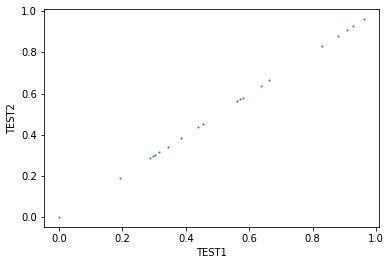

In [1]:
from scipy.stats import binom 
import os
import numpy as np

import matplotlib as mpl



main_Dict = {}



class event:
    eventno = 0
    eType = ""
    eSend = 0
    eRecv = -1
    eInt = False
    eVclock = []
    eBclock = []
    ePair = []
    eHashIdx = []

    def print(priEvent):
        print("eventno => ",priEvent.eventno)
        print("eType => ",priEvent.eType)
        print("eSend => ",priEvent.eSend)
        print("eRecv => ",priEvent.eRecv)
        print("eInt => ",priEvent.eInt)
        print("eVclock => ",priEvent.eVclock)
        print("eBclock => ",priEvent.eBclock)
        print("ePair => ",priEvent.ePair)
        print("eHashIdx => ",priEvent.eHashIdx)


def getfilename(foldername):
    file_names = filter((lambda x:x[-3:] == 'txt'),os.listdir(os.getcwd()+"/"+foldername))
    return sorted(list(file_names))



def make_dict(file_name):
    with open(file_name,"r") as fin:
        data = fin.read().split("\n")

    totalGSN = int(data[-3].split(" ")[-2])
    lineNo = 0
    currEvent = 1
    eventList = [None] * (totalGSN+1)
    eventList[0] = event()

    while True:
        tempLine = data[lineNo]
        tempVclock = data[lineNo+1]
        tempBclock = data[lineNo+2]

        eventLine = tempLine.split(",")
        if currEvent != int(eventLine[0]):
            print("PANIC",file_name,currEvent,lineNo)
            break

        tempEvent = get_event(eventLine,tempVclock,tempBclock)
        eventList[currEvent] = tempEvent

        if currEvent == totalGSN:
            break

        currEvent += 1
        lineNo += 3

    return eventList    



def get_file_prp(file_name):
    eventList = main_Dict[file_name]

    n = int(file_name[1:4])
    m = n * float(file_name[5:8])
    baseEvent = eventList[10*n]
    idx = (10*n)+10
    print(idx,"ALONE")
    gsnlst = []
    prplst = []
    while idx < ((n*n)+20*n):
        gsnlst.append(idx)
        prplst.append(get_event_prp(baseEvent,eventList[idx],m))
        idx += 10

    return gsnlst,prplst

def get_file_prfp(gsnlst, prplst,eventSlice,n):
    baseEvent = eventSlice[10*n]
    prfplst = []
    for idx,val in enumerate(gsnlst):
        prdelta = int(check_two_events_bloom(baseEvent,eventSlice[val]))
        prfplst.append((1 - prplst[idx]) * prdelta)

    return gsnlst, prfplst
# 
def get_event_prp(beforeEvent,afterEvent,bloomsize):
    ans = 1
    bzSum = sum(afterEvent.eBclock)
    for idx,val in enumerate(beforeEvent.eBclock):
        result = 0
        pSuccess = 1/float(bloomsize)
        for val in range(0,val):
            result += binom.pmf(val, bzSum, pSuccess)

        ans = ans *(1 - result)
    return ans



def check_two_events_vec(beforeEvent,afterEvent):
    flag = True
    if beforeEvent.eVclock == afterEvent.eVclock:
        return False

    for idx,val in enumerate(beforeEvent.eVclock):
        if val > afterEvent.eVclock[idx]:
            flag = False


    return flag

def check_two_events_bloom(beforeEvent,afterEvent):
    flag = True
    if beforeEvent.eBclock == afterEvent.eBclock:
        return False
    for idx,val in enumerate(beforeEvent.eBclock):
        if val > afterEvent.eBclock[idx]:
            flag = False
            
    return flag

def get_event(eventLinearr,tempVclock,tempBclock):
    result = event()

    result.eventno = int(eventLinearr[0])
    result.eType = eventLinearr[1]
    result.eSend = int(eventLinearr[2])
    if result.eType == "INTERNAL EVENT":
        result.eInt = True
    else:
        result.eRecv = int(eventLinearr[3])

    result.eVclock = get_vector(tempVclock)
    result.eBclock = get_vector(tempBclock)
    
    result.ePair = eventLinearr[4]
    result.eHashIdx = eventLinearr[5]

    return result

def get_vector(vectorline):
    tempLine = vectorline[1:-1]
    vectorClock = list(map((lambda x:int(x)),tempLine.split(" ")))

    return vectorClock

def get_metrics(eventSlice,n):
    indecies = list(range(10*n,n*n+20*n,100))

    totalTP = 0
    totalTN = 0
    totalFP = 0
    totalFN = 0



    for idx,valx in enumerate(indecies[:-1]):
        for valy in indecies[idx+1:]:
            bflag = check_two_events_bloom(eventSlice[valx],eventSlice[valy])
            if bflag:
                if check_two_events_vec(eventSlice[valx],eventSlice[valy]):
                    # True Positive
                    totalTP += 1
                else:
                    # False Positive
                    totalFP += 1
                # bflag True => Bz >= By Possitive Case
            else:
                # True Negative
                totalTN += 1

#     print(totalTP,totalTN,totalFP,totalFN)
    sliceAccuracy = get_accuracy(totalTP,totalTN,totalFP,totalFN)
    slicePrecision = get_precision(totalTP,totalTN,totalFP,totalFN)
    slicefpr = get_fpr(totalTP,totalTN,totalFP,totalFN)

    return sliceAccuracy,slicePrecision,slicefpr


def get_accuracy(tp,tn,fp,fn):
    accuracy = float(tp+tn)/(tp+tn+fp+fn)
    return accuracy

def get_precision(tp,tn,fp,fn):
    precision = float(tp)/(tp+fp)
    return precision

def get_fpr(tp,tn,fp,fn):
    fpr = float(fp)/(tn+fp)
    return fpr
    
def get_file_list(keylist,filelist):
    result_list = []
    for name in filelist:
        flag = True
        for val in keylist:
            if val not in name:
                flag = False
                break
        if flag == True:
            result_list.append(name) 

    return result_list

def get_actual_p_n(gsnlst, prplst,eventSlice,n):
    base_event = eventSlice[10*n]
    t_gsnlst = []
    t_prlst = []
    f_gsnlst = []
    f_prlst = []
    n_gsnlst =[]
    n_prlst = []

    for idx,val in enumerate(gsnlst):
            bflag = check_two_events_bloom(base_event,eventSlice[val])
            if bflag:
                if check_two_events_vec(base_event,eventSlice[val]):
                    # True Positive
                    t_gsnlst.append(val)
                    t_prlst.append(prplst[idx])
                else:
                    # False Positive
                    f_gsnlst.append(val)
                    f_prlst.append(prplst[idx])
            else:
                # True Negative
                n_gsnlst.append(val)
                n_prlst.append(prplst[idx])
            
            
            
    return t_gsnlst, t_prlst, f_gsnlst, f_prlst, n_gsnlst, n_prlst

mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt


dumy_x = np.random.rand(20)
dumy_y = np.random.rand(20)

plt.scatter(dumy_x,dumy_x,s=1)
plt.xlabel("TEST1")
plt.ylabel("TEST2")
plt.show()




In [2]:
foldername = 'runs90'
file_names = getfilename(foldername)
all_files = []
for val in file_names:
    all_files.append(val)

# temp_keys = ["100"]
# newlist = get_file_list(temp_keys,all_files)
# print("Current List =>",newlist)
# for val in newlist:
#     print("Reading ", val)
#     main_Dict[val[:-4]] = make_dict(foldername+"/"+val)

# temp_keys = ["200"]
# newlist = get_file_list(temp_keys,all_files)
# print("Current List =>",newlist)
# for val in newlist:
#     print("Reading ", val)
#     main_Dict[val[:-4]] = make_dict(foldername+"/"+val)
    
# temp_keys = ["300","0.1"]
# newlist = get_file_list(temp_keys,all_files)
# print("Current List =>",newlist)
# for val in newlist:
#     print("Reading ", val)
#     main_Dict[val[:-4]] = make_dict(foldername+"/"+val)
    
# temp_keys = ["300","0.2"]
# newlist = get_file_list(temp_keys,all_files)
# print("Current List =>",newlist)
# for val in newlist:
#     print("Reading ", val)
#     main_Dict[val[:-4]] = make_dict(foldername+"/"+val)
    
temp_keys = ["300","0.3"]
newlist = get_file_list(temp_keys,all_files)
print("Current List =>",newlist)
for val in newlist:
    print("Reading ", val)
    main_Dict[val[:-4]] = make_dict(foldername+"/"+val)
    

print("FilesREAD")



Current List => ['n300b0.1h2.txt', 'n300b0.1h3.txt', 'n300b0.1h4.txt']
Reading  n300b0.1h2.txt
Reading  n300b0.1h3.txt
Reading  n300b0.1h4.txt
Current List => ['n300b0.2h2.txt', 'n300b0.2h3.txt', 'n300b0.2h4.txt']
Reading  n300b0.2h2.txt
Reading  n300b0.2h3.txt
Reading  n300b0.2h4.txt
FilesREAD


In [3]:


# for idx,val in enumerate(main_Dict):
# #     print(idx,val)
#     xAxis,yAxis = get_file_prp(val)
#     t_gsnlst, t_prlst, f_gsnlst, f_prlst, n_gsnlst, n_prlst = get_actual_p_n(xAxis,yAxis,main_Dict[val],int(val[1:4]))    
#     fig = plt.figure()
#     plt.scatter(t_gsnlst,t_prlst,s=3,color='green', label='True Positive Points')
#     plt.scatter(f_gsnlst,f_prlst,s=3,color='#ff9900', label='False Positive Points')
#     plt.scatter(n_gsnlst,n_prlst,s=3,color='red', label='True Negative Points')
#     plt.xlabel("Gsn")
#     plt.ylabel("Prp")
#     plt.legend(loc='lower right')
#     plt.title("Prp vs GSN \nProcess ="+val[1:4]+" Bloom Factor ="+val[5:8]+"n Hash Function = "+val[9])
#     plt.show()
#     fig.savefig('Prp '+val+'.png', bbox_inches='tight')
#     plt.close()
    
#     xAxis,yAxis = get_file_prfp(xAxis,yAxis,main_Dict[val],int(val[1:4]))
#     fig = plt.figure()
#     plt.scatter(xAxis,yAxis,s=1)
#     t_gsnlst, t_prlst, f_gsnlst, f_prlst, n_gsnlst, n_prlst = get_actual_p_n(xAxis,yAxis,main_Dict[val],int(val[1:4]))
#     plt.scatter(t_gsnlst,t_prlst,s=3,color='green', label='True Positive Points')
#     plt.scatter(f_gsnlst,f_prlst,s=3,color='#ff9900', label='False Positive Points')
#     plt.scatter(n_gsnlst,n_prlst,s=3,color='red', label='True Negative Points')
#     plt.xlabel("Gsn")
#     plt.ylabel("Prfp")
#     plt.legend(loc='upper right')
#     plt.title("Prfp vs GSN \nProcess ="+val[1:4]+" Bloom Factor ="+val[5:8]+"n Hash Function = "+val[9])
#     fig.savefig('Prfp '+val+'.png', bbox_inches='tight')
#     plt.show()


print("Filename","accuracy","precision","fpr")
for val in main_Dict:
    metrics = get_metrics(main_Dict[val],int(val[1:4]))
    print(val,metrics[0],metrics[1],metrics[2])

    

Filename accuracy precision fpr
n300b0.1h2 0.7566952556223017 0.7173635948046361 0.6361495953855186
n300b0.1h3 0.7544289732282371 0.7181926373001662 0.656332364041329
n300b0.1h4 0.7414030579765502 0.7042079732248772 0.6728261589703127
n300b0.2h2 0.7943840642614906 0.7497344434582929 0.5354234355879995
n300b0.2h3 0.7889093371297614 0.746891940278622 0.5597790055248619
n300b0.2h4 0.7707767630820515 0.7263675955299606 0.5854727132974635
